 # **MOVIE RECOMMENDATION SYSTEM**

# **1.** **SETUP SPARK SESSION AND LOADING DATA**

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=e927864a497d3907156c4d9afb5b4bece1ce65d1660e93f4a77dea6e36e19d2f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Check for active SparkContext
if 'sc' in locals() or 'sc' in globals():
    sc.stop()

In [3]:
import os
from pyspark.sql import SparkSession

# Define the Kaggle data directory
kaggle_data_dir = "/kaggle/input/movie-recommendation/ml-latest"

# Create a Spark session
spark = SparkSession.builder.master("local").appName("MovieRecommendation").getOrCreate()

# Read the ratings data
ratings_df = spark.read.csv(os.path.join(kaggle_data_dir, "ratings.csv"), header=True)

# Read the movies data
movies_df = spark.read.csv(os.path.join(kaggle_data_dir, "movies.csv"), header=True)

# Join the ratings and movies DataFrames using an inner join on the "movieId" column
df = ratings_df.join(movies_df, on="movieId", how="inner")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/05 21:03:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df.head()

Row(movieId='1', userId='1', rating='4.0', timestamp='1225734739', title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy')

In [5]:
df.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [6]:
df.head(5)

[Row(movieId='1', userId='1', rating='4.0', timestamp='1225734739', title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId='110', userId='1', rating='4.0', timestamp='1225865086', title='Braveheart (1995)', genres='Action|Drama|War'),
 Row(movieId='158', userId='1', rating='4.0', timestamp='1225733503', title='Casper (1995)', genres='Adventure|Children'),
 Row(movieId='260', userId='1', rating='4.5', timestamp='1225735204', title='Star Wars: Episode IV - A New Hope (1977)', genres='Action|Adventure|Sci-Fi'),
 Row(movieId='356', userId='1', rating='5.0', timestamp='1225735119', title='Forrest Gump (1994)', genres='Comedy|Drama|Romance|War')]

# **2.** **DATA PRE-PROCESSING**

In [7]:
from pyspark.sql import SparkSession

# Assuming 'your_data' is the DataFrame containing your movie data
# Create a Spark session
spark = SparkSession.builder.appName("TruncateDataset").getOrCreate()

# Assuming 'your_data' is your DataFrame
data = df.limit(100000)

# Show the first few rows of the truncated DataFrame
data.show()


23/12/05 21:03:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|      1|     1|   4.0|1225734739|    Toy Story (1995)|Adventure|Animati...|
|    110|     1|   4.0|1225865086|   Braveheart (1995)|    Action|Drama|War|
|    158|     1|   4.0|1225733503|       Casper (1995)|  Adventure|Children|
|    260|     1|   4.5|1225735204|Star Wars: Episod...|Action|Adventure|...|
|    356|     1|   5.0|1225735119| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    381|     1|   3.5|1225734105|When a Man Loves ...|       Drama|Romance|
|    596|     1|   4.0|1225733524|    Pinocchio (1940)|Animation|Childre...|
|   1036|     1|   5.0|1225735626|     Die Hard (1988)|Action|Crime|Thri...|
|   1049|     1|   3.0|1225734079|Ghost and the Dar...|    Action|Adventure|
|   1066|     1|   4.0|1225736961|Shall We Dance (1...|Comedy|Musical|Ro...|

In [8]:
data.describe().show()

23/12/05 21:03:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+--------------------+--------------------+------------------+
|summary|          movieId|            userId|            rating|           timestamp|               title|            genres|
+-------+-----------------+------------------+------------------+--------------------+--------------------+------------------+
|  count|           100000|            100000|            100000|              100000|              100000|            100000|
|   mean|      29302.86026|         518.05957|          3.575805|  1.28295984354658E9|                NULL|              NULL|
| stddev|50536.88807230559|302.10621026889964|1.0490052936453964|2.6066749111431932E8|                NULL|              NULL|
|    min|                1|                 1|               0.5|          1000092143|"""Great Performa...|(no genres listed)|
|    max|            99986|               999|               5.0|           999998185|À propos de Nice ...|    

In [9]:
data_na = data.na.drop()

In [10]:
# Convert data types
data = data.withColumn("rating", data["rating"].cast("float"))


In [11]:
from pyspark.sql.functions import col, regexp_extract

# Extract year from title
data = data.withColumn("year", regexp_extract(col("title"), "\((\d{4})\)", 1).cast("int"))


In [12]:
# Drop unnecessary columns
data = data.drop("timestamp", "genres")


In [13]:
# Print the DataFrame schema
data.printSchema()

# Show the first few rows of the DataFrame
data.show(5)


root
 |-- movieId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)

+-------+------+------+--------------------+----+
|movieId|userId|rating|               title|year|
+-------+------+------+--------------------+----+
|      1|     1|   4.0|    Toy Story (1995)|1995|
|    110|     1|   4.0|   Braveheart (1995)|1995|
|    158|     1|   4.0|       Casper (1995)|1995|
|    260|     1|   4.5|Star Wars: Episod...|1977|
|    356|     1|   5.0| Forrest Gump (1994)|1994|
+-------+------+------+--------------------+----+
only showing top 5 rows



# **3. VISUALIZATION**

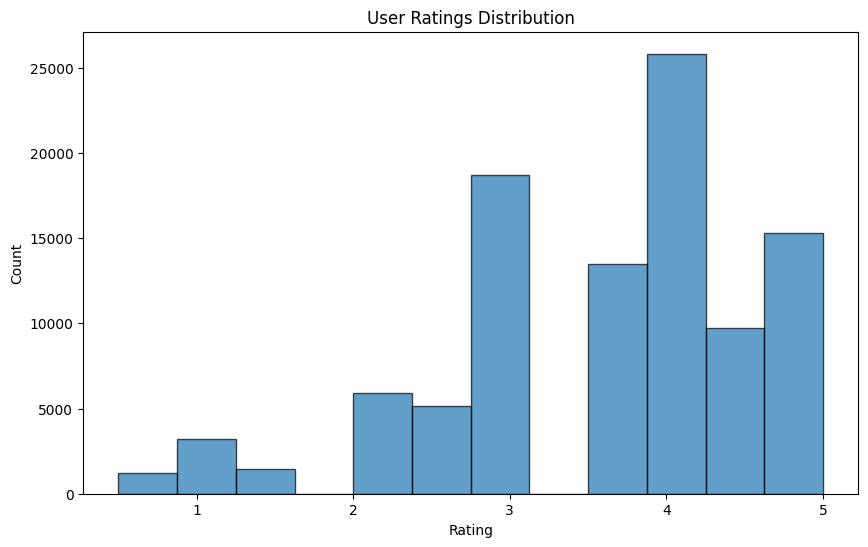

In [14]:
import matplotlib.pyplot as plt

# Convert rating column to float
data = data.withColumn("rating", data["rating"].cast("float"))

# Extract ratings as a Pandas DataFrame
ratings_pd = data.select("rating").toPandas()

# Plot User Ratings Distribution
plt.figure(figsize=(10, 6))
plt.hist(ratings_pd['rating'], bins=12, edgecolor='black', alpha=0.7)
plt.title('User Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


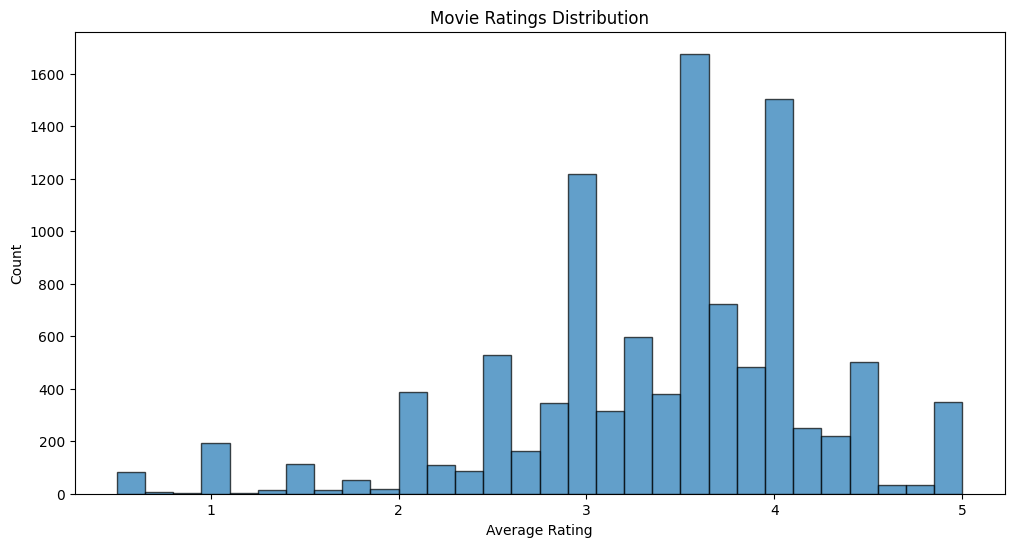

In [15]:
# Extract movie ratings as a Pandas DataFrame
movie_ratings_pd = data.groupBy("movieId").avg("rating").toPandas()

# Plot Movie Ratings Distribution
plt.figure(figsize=(12, 6))
plt.hist(movie_ratings_pd['avg(rating)'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Movie Ratings Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()


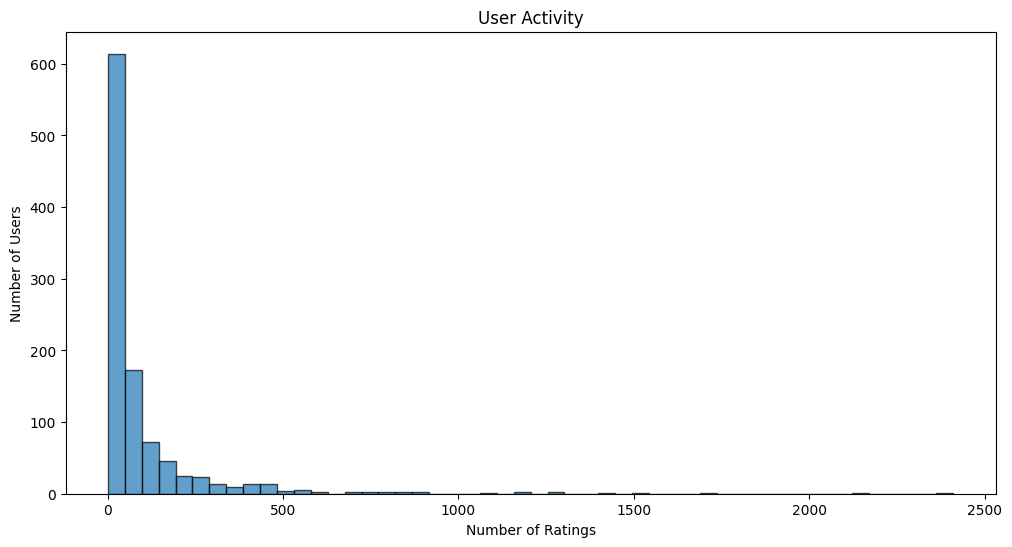

In [16]:
# Extract user activity as a Pandas DataFrame
user_activity_pd = data.groupBy("userId").count().toPandas()

# Plot User Activity
plt.figure(figsize=(12, 6))
plt.hist(user_activity_pd['count'], bins=50, edgecolor='black', alpha=0.7)
plt.title('User Activity')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


# **4. COLLABORATIVE FILTER MODELLING**

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [18]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

# Assuming df is your preprocessed DataFrame
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# Indexing the "userId" column
indexer_user = StringIndexer(inputCol="userId", outputCol="numericUserId")
train_data = indexer_user.fit(train_data).transform(train_data)
test_data = indexer_user.fit(test_data).transform(test_data)  # Apply the same transformation to test_data

# Indexing the "movieId" column
indexer_movie = StringIndexer(inputCol="movieId", outputCol="numericMovieId")
train_data = indexer_movie.fit(train_data).transform(train_data)
test_data = indexer_movie.fit(test_data).transform(test_data)  # Apply the same transformation to test_data

# Create an ALS model
als = ALS(userCol="numericUserId", itemCol="numericMovieId", ratingCol="rating", coldStartStrategy="drop")

# Fit the model
model = als.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)


23/12/05 21:04:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/05 21:04:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [19]:
predictions.show()

+-------+------+------+----------------+----+-------------+--------------+----------+
|movieId|userId|rating|           title|year|numericUserId|numericMovieId|prediction|
+-------+------+------+----------------+----+-------------+--------------+----------+
|      1|  1000|   3.5|Toy Story (1995)|1995|        320.0|          36.0|  4.346814|
|      1|  1010|   3.0|Toy Story (1995)|1995|        528.0|          36.0| 3.9259002|
|      1|  1013|   3.0|Toy Story (1995)|1995|        490.0|          36.0| 4.5100193|
|      1|  1025|   5.0|Toy Story (1995)|1995|        492.0|          36.0| 3.8465075|
|      1|   112|   4.5|Toy Story (1995)|1995|        566.0|          36.0|  3.988811|
|      1|   135|   3.0|Toy Story (1995)|1995|        363.0|          36.0|  4.538728|
|      1|   170|   5.0|Toy Story (1995)|1995|        131.0|          36.0|  3.947177|
|      1|   187|   2.0|Toy Story (1995)|1995|        191.0|          36.0|  3.106883|
|      1|    21|   3.0|Toy Story (1995)|1995|         

# **5. MODEL EVALUATION**

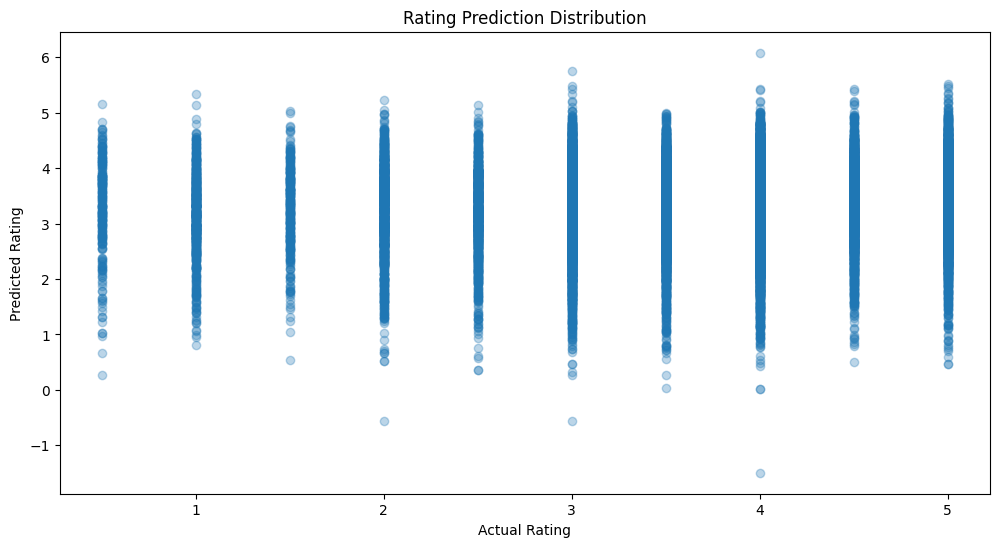

In [20]:
# Extract prediction results as a Pandas DataFrame
predictions_pd = predictions.select("rating", "prediction").toPandas()

# Plot Rating Prediction Distribution
plt.figure(figsize=(12, 6))
plt.scatter(predictions_pd['rating'], predictions_pd['prediction'], alpha=0.3)
plt.title('Rating Prediction Distribution')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()


In [21]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.2548138301087546


In [22]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model using MAE
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = evaluator_mae.evaluate(predictions)

print("Mean Absolute Error (MAE): {:.4f}".format(mae))


Mean Absolute Error (MAE): 1.0019


In [23]:
# Calculate the coverage of recommendations
unique_movies = predictions.select("movieId").distinct().count()
total_movies = data.select("movieId").distinct().count()
coverage = (unique_movies / total_movies) * 100

print("Coverage of Recommendations: {:.2f}%".format(coverage))


Coverage of Recommendations: 49.05%


# **6. INDIVIDUAL USER RECOMMENDATIONS**

In [24]:
single_user = test_data.filter(test_data['userId'] == 12).select(['movieId', 'userId', 'rating'])

# Join with movies_df to get movie names
single_user_with_names_and_ratings = single_user.join(movies_df, on="movieId", how="inner").select("movieId", "title", "userId", "rating")

# Display the result
single_user_with_names_and_ratings.show()


+-------+--------------------+------+------+
|movieId|               title|userId|rating|
+-------+--------------------+------+------+
|    653|  Dragonheart (1996)|    12|   3.0|
|    733|    Rock, The (1996)|    12|   5.0|
|    849|Escape from L.A. ...|    12|   4.0|
|    879|   Relic, The (1997)|    12|   4.0|
|    990| Maximum Risk (1996)|    12|   5.0|
|   1498|Inventing the Abb...|    12|   5.0|
+-------+--------------------+------+------+



# **7. TOP RECOMMENDED MOVIES**

In [25]:


import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode

# Replace 'user_id_to_recommend' with the actual user ID
user_id_to_recommend = 3

# Get top-N recommendations for a specific user
top_n_recommendations = model.recommendForUserSubset(test_data.filter(test_data['userId'] == user_id_to_recommend), 5)



In [26]:
# Explode the recommendations array to individual rows
exploded_recommendations = top_n_recommendations.select(
    col("numericUserId"),
    explode(col("recommendations")).alias("recommendation")
)

# Extract movieId and rating from the exploded column
recommendations_data = exploded_recommendations.select(
    col("recommendation.numericMovieId").alias("movieId"),
    col("recommendation.rating").alias("rating")
)
# Create a Spark DataFrame from the recommendations data
spark = SparkSession.builder.appName("example").getOrCreate()

movies_data = spark.read.csv("/kaggle/input/movie-recommendation/ml-latest/movies.csv", header=True, inferSchema=True)

spark_recommendations = recommendations_data.join(movies_data.select("movieId", "title"), on="movieId", how="inner")

# Convert to Pandas DataFrame for plotting
pandas_data = spark_recommendations.toPandas()

movies_data.printSchema()

23/12/05 21:05:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



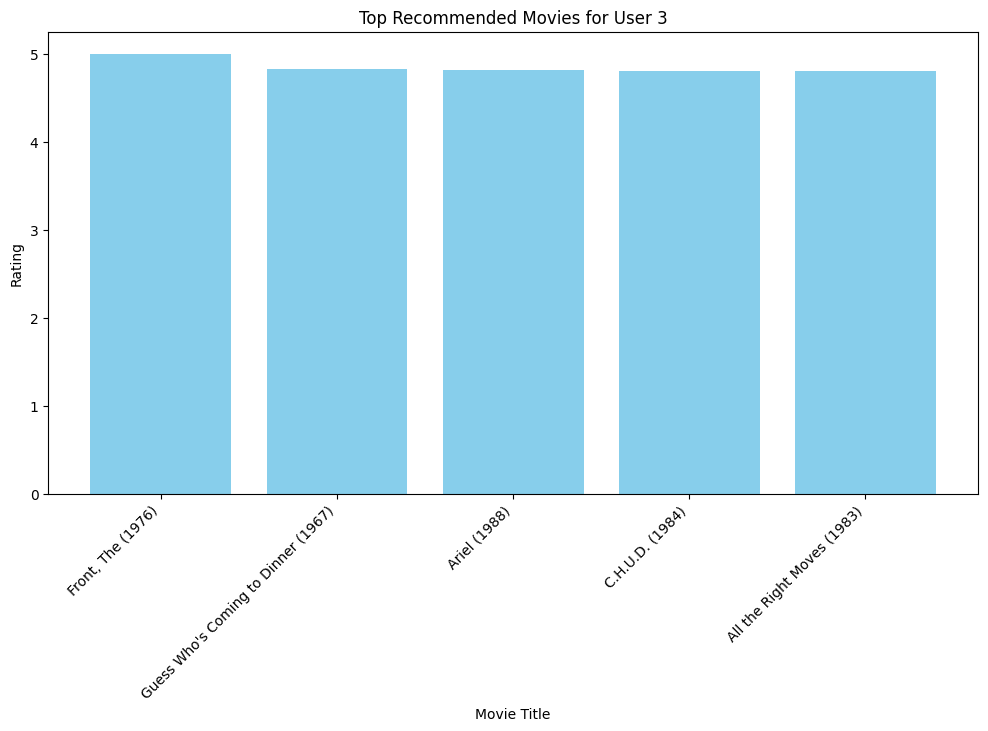

In [27]:
# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(pandas_data['title'], pandas_data['rating'], color='skyblue')
plt.title(f'Top Recommended Movies for User {user_id_to_recommend}')
plt.xlabel('Movie Title')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()
